## Timings test
### Scipy benchmark

In [1]:
import numpy as np
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
from foostrap import foostrap

#### Generate data for the different statistics

In [2]:
n1 = 1000 # Sample size 1
n2 = 100 # Sample size 2
prob_1 = 0.22 # Proportion of non-zeros on x1
prob_2 = 0.2 # Proportion of non-zeros on x2
sigma = 2.0 # Lognormal scale parameter
n_boots = 100000 # Bootstrap samples

rng = np.random.Generator(np.random.SFC64(0))
nnz1 = int(prob_1 * n1)
nnz2 = int(prob_2 * n2)
nz1 = n1 - nnz1
nz2 = n2 - nnz2

# Sparse 1D arrays for mean statistic
x = np.concatenate((np.zeros(nz1), rng.lognormal(sigma= sigma, size= nnz1) + 0.2))
y = np.concatenate((np.zeros(nz2), rng.lognormal(sigma= sigma, size= nnz2)))

# 2D arrays for ratio statistic
z = np.concatenate((x.reshape(-1,1), rng.lognormal(sigma= sigma, size= (n1,1))), axis= 1)
w = np.concatenate((y.reshape(-1,1), rng.lognormal(sigma= sigma, size= (n2,1))), axis= 1)

# Binary 1D arrays for mean statistic
xb = np.concatenate((np.zeros(nz1), np.ones(nnz1)))
yb = np.concatenate((np.zeros(nz2), np.ones(nnz2)))

#### Scipy mean statistic on sparse 1D arrays

In [3]:
def mean_dif(x, y, axis= -1):
    return np.mean(x, axis= axis) - np.mean(y, axis= axis)

In [4]:
%timeit bootstrap((x,y), mean_dif, vectorized= True, random_state= rng, method= 'BCa', batch= 1000, n_resamples= n_boots)
res_sp = bootstrap((x,y), mean_dif, vectorized= True, random_state= rng, method= 'BCa', batch= 1000, n_resamples= n_boots)

967 ms ± 36.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Foostrap mean statistic, 3 timings:
1. Default execution on sparse array
2. Treating array as dense (slower)
3. Forcing single core execution

In [5]:
# Example 1: Taking advantage of sparsity
res_bs = foostrap(x, y, random_state= None, boot_samples= n_boots) #First execution is longer, due to Numba compilation
%timeit -n 10 -r 10 foostrap(x, y, random_state= rng, boot_samples= n_boots)

34 ms ± 1.04 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [6]:
# Example 2: Treating the input as dense, still parallel
foostrap(x, y, random_state= 0, boot_samples= 100, ignore_sparse_below= 1.0) # First run just to compile function (for dense input)
%timeit -n 5 -r 10 foostrap(x, y, random_state= rng, boot_samples= n_boots, ignore_sparse_below= 1.0)

87 ms ± 11.1 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [7]:
# Example 3: Treating the input as dense, and single core (closest to Scipy)
%timeit -n 3 -r 10 foostrap(x, y, random_state= rng, boot_samples= n_boots, ignore_sparse_below= 1.0, parallel= False)

375 ms ± 25.4 ms per loop (mean ± std. dev. of 10 runs, 3 loops each)


#### Histogram of bootstrap samples (mean difference)

Scipy:  ConfidenceInterval(low=-4.9683288454388315, high=0.33468700768197784)
Foostrap:  (-4.983478198811563, 0.3529670064766315)


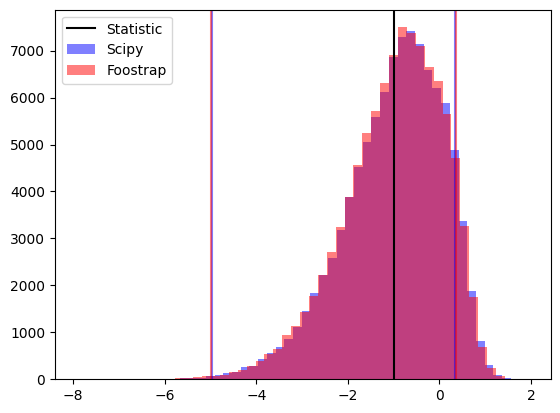

In [8]:
print('Scipy: ', res_sp.confidence_interval)
print('Foostrap: ', res_bs.ci)
plt.hist(res_sp.bootstrap_distribution, bins= 50, color= (0,0,1,0.5))
plt.hist(res_bs.boot_samples, bins= 50, color= (1,0,0,0.5))
plt.axvline(x.mean() - y.mean(), color = (0,0,0,1))
plt.legend(['Statistic','Scipy','Foostrap'])
plt.axvline(res_sp.confidence_interval.low, color = (0,0,1,0.5))
plt.axvline(res_sp.confidence_interval.high, color = (0,0,1,0.5))
plt.axvline(res_bs.ci[0], color = (1,0,0,0.5))
plt.axvline(res_bs.ci[1], color = (1,0,0,0.5))
plt.show()

#### Scipy ratio statistic on 2D arrays

In [9]:
def ratio_dif(x, y, axis= -1):
    return x[0].sum(axis= axis) / x[1].sum(axis= axis) - y[0].sum(axis= axis) / y[1].sum(axis= axis)
%timeit bootstrap((z,w), ratio_dif, vectorized= True, random_state= rng, method= 'BCa', batch= 1000, n_resamples= n_boots)
res_spr = bootstrap((z,w), ratio_dif, vectorized= True, random_state= rng, method= 'BCa', batch= 1000, n_resamples= n_boots)

2.39 s ± 77.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Foostrap ratio statistic

In [10]:
#Example 4: ratio metric (takes x2 time vs dense multicore case)
res_bsr = foostrap(z, w, random_state= np.random.SeedSequence(0), boot_samples= n_boots)
%timeit -n 3 -r 10 foostrap(z, w, random_state= rng, boot_samples= n_boots)

208 ms ± 38.5 ms per loop (mean ± std. dev. of 10 runs, 3 loops each)


#### Histogram of bootstrap samples (ratio difference)

Scipy:  ConfidenceInterval(low=-0.5330076611384754, high=0.1300041136674153)
Foostrap:  (-0.5234166034446556, 0.13003974587504213)


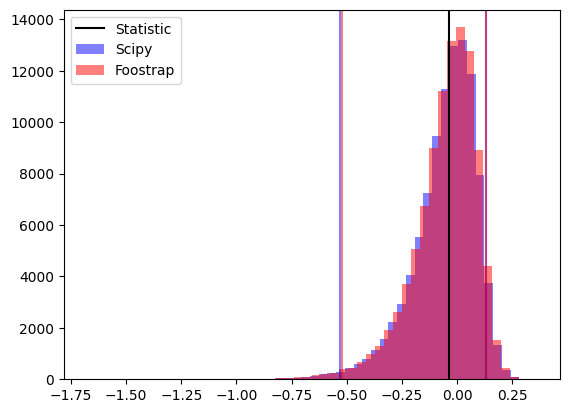

In [11]:
print('Scipy: ', res_spr.confidence_interval)
print('Foostrap: ', res_bsr.ci)
plt.hist(res_spr.bootstrap_distribution, bins= 50, color= (0,0,1,0.5))
plt.hist(res_bsr.boot_samples, bins= 50, color= (1,0,0,0.5))
plt.axvline(z.sum(axis= 0)[0]/z.sum(axis= 0)[1] - w.sum(axis= 0)[0]/w.sum(axis= 0)[1], color = (0,0,0,1))
plt.legend(['Statistic','Scipy','Foostrap'])
plt.axvline(res_spr.confidence_interval.low, color = (0,0,1,0.5))
plt.axvline(res_spr.confidence_interval.high, color = (0,0,1,0.5))
plt.axvline(res_bsr.ci[0], color = (1,0,0,0.5))
plt.axvline(res_bsr.ci[1], color = (1,0,0,0.5))
plt.show()

#### Scipy mean statistic on binary data

In [12]:
# Scipy (should take around the same time as the first case)
%timeit bootstrap((xb,yb), mean_dif, vectorized= True, random_state= rng, method= 'BCa', batch= 1000, n_resamples= n_boots)
res_spb = bootstrap((xb,yb), mean_dif, vectorized= True, random_state= rng, method= 'BCa', batch= 1000, n_resamples= n_boots)

749 ms ± 37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Foostrap mean statistic on binary data

In [15]:
# Example 5: binary metric (very fast because it only generates n_boots binomials)
res_bsb = foostrap(xb, yb, random_state= 0, boot_samples= n_boots)
%timeit -n 10 -r 10 foostrap(xb, yb, random_state= rng, boot_samples= n_boots)

18.3 ms ± 395 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


#### Histogram of bootstrap samples (mean difference on binary data)

Scipy:  ConfidenceInterval(low=-0.07199999999999998, high=0.094)
Foostrap:  (-0.07100000000000001, 0.095)


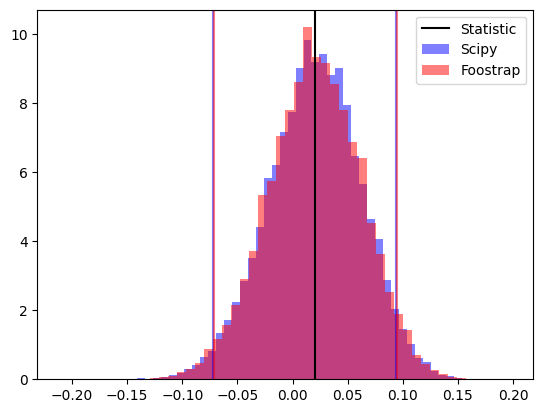

In [14]:
print('Scipy: ', res_spb.confidence_interval)
print('Foostrap: ', res_bsb.ci)
plt.hist(res_spb.bootstrap_distribution, bins= 50, color= (0,0,1,0.5), density= True)
plt.hist(res_bsb.boot_samples, bins= 50, color= (1,0,0,0.5), density= True)
plt.axvline(xb.mean() - yb.mean(), color = (0,0,0,1))
plt.legend(['Statistic','Scipy','Foostrap'])
plt.axvline(res_spb.confidence_interval.low, color = (0,0,1,0.5))
plt.axvline(res_spb.confidence_interval.high, color = (0,0,1,0.5))
plt.axvline(res_bsb.ci[0], color = (1,0,0,0.5))
plt.axvline(res_bsb.ci[1], color = (1,0,0,0.5))
plt.show()